In [133]:
%matplotlib inline

from collections import Counter, defaultdict
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats.stats import pearsonr
import cPickle as pkl
import sys
from datetime import datetime
from sklearn.ensemble import *
import seaborn as sns
from hmmlearn import hmm
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import *
from sklearn.svm import *
from sklearn.linear_model import Ridge

In [2]:
type_enc = {u'MemberEvent_diff': 19, u'IssuesEvent_same': 12, u'DeleteEvent_same': 6, u'IssuesEvent_diff': 26, u'PullRequestReviewCommentEvent_diff': 16, u'CreateEvent_diff': 27, u'DeleteEvent_diff': 20, u'ReleaseEvent_diff': 14, u'CreateEvent_same': 13, u'CommitCommentEvent_same': 10, u'ReleaseEvent_same': 0, u'PublicEvent_diff': 15, u'WatchEvent_same': 11, u'IssueCommentEvent_diff': 21, u'PullRequestReviewCommentEvent_same': 2, u'PullRequestEvent_diff': 23, u'PublicEvent_same': 1, u'ForkEvent_diff': 17, u'GollumEvent_diff': 18, u'CommitCommentEvent_diff': 24, u'GollumEvent_same': 4, u'PushEvent_same': 8, u'PullRequestEvent_same': 9, u'ForkEvent_same': 3, u'WatchEvent_diff': 25, u'IssueCommentEvent_same': 7, u'MemberEvent_same': 5, u'PushEvent_diff': 22}

In [56]:
rdata, udata, data, users, repos = pkl.load(open('dataset720_pruned_2_40.pkl', 'rb')) # LOAD

In [64]:
rinput = defaultdict(list)
for u,r in data.keys():
    if len(data[(u,r)]['actions']) > 10:
        rinput[r].append([type_enc[a+'_same'] for a in data[(u,r)]['actions']])

In [66]:
print len([r for r in rinput.keys() if len(rinput[r]) > 5])

717


In [97]:
lentrain = int(len(rinput) * .8)
rtrain = rinput.items()[:lentrain]
rtest = rinput.items()[lentrain:lentrain * 2]

In [98]:
hmmdata_train = []
hmmdata_test = []
for r,d in rtrain:
    hmmdata_train.extend(d)
lens_train = [len(h) for h in hmmdata_train]

for r,d in rtest:
    hmmdata_test.extend(d)
lens_test = [len(h) for h in hmmdata_test]



In [99]:
X_train = np.concatenate(hmmdata_train)
X_test = np.concatenate(hmmdata_test)

In [100]:
print len(X_train)

2455372


In [75]:
n_components = 10
model = hmm.MultinomialHMM(n_components=n_components, n_iter=20, algorithm='viterbi')

In [76]:
model.fit(np.atleast_2d(X_train).T,lens_train)

MultinomialHMM(algorithm='viterbi', init_params='ste', n_components=10,
        n_iter=20, params='ste',
        random_state=<mtrand.RandomState object at 0x7f85f41021e0>,
        startprob_prior=1.0, tol=0.01, transmat_prior=1.0, verbose=False)

In [77]:
pkl.dump(model, open('HMM_.2.pkl', 'wb'))

In [78]:
label_encodings = ['MemberEvent_same',
 'PublicEvent_same',
 'PullRequestReviewCommentEvent_same',
 'ForkEvent_same',
 'GollumEvent_same',
 'ReleaseEvent_same',
 'PullRequestEvent_same',
 'IssueCommentEvent_same',
 'PushEvent_same',
 'DeleteEvent_same',
 'CommitCommentEvent_same',
 'WatchEvent_same',
 'IssuesEvent_same',
 'CreateEvent_same']

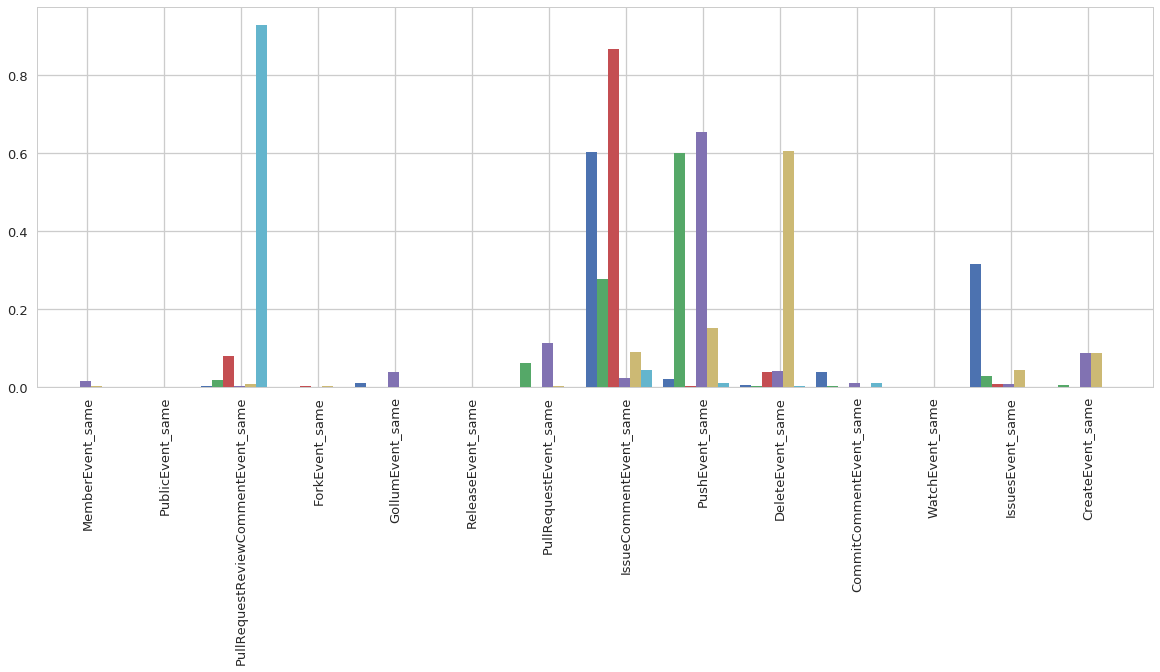

In [36]:
sns.set_style('whitegrid')
sns.set_context('talk')

xcoords = np.arange(14)
plt.figure(figsize=(20,7))
ax = plt.subplot(111)
xcoord = .3
colors = sns.color_palette()
for n in range(n_components):
    ax.bar(xcoords - xcoord + n*1./(n_components+1), model.emissionprob_[n], width = 1./(n_components+1), color=colors[n])
ax.set_xticklabels(label_encodings, rotation='vertical')

plt.xlim([-.5,14])
plt.xticks(np.arange(0,14)+.15)

plt.show()


In [101]:
repo_states_train = defaultdict(list)
repo_states_test = defaultdict(list)

for r, d in rtrain:
    for  u in d:
        repo_states_train[r].append(model.predict(np.atleast_2d(u).T))
        
for r, d in rtest:
    for  u in d:
        repo_states_test[r].append(model.predict(np.atleast_2d(u).T))

In [102]:
repo_props_train = defaultdict(list)
for r in repo_states_train.keys():
    for l in repo_states_train[r]:
        c = Counter(l)
        sp = np.array([float(c[i])/sum(c.values()) for i in range(n_components)])
        repo_props_train[r].append(sp)

repo_props_test = defaultdict(list)
for r in repo_states_test.keys():
    for l in repo_states_test[r]:
        c = Counter(l)
        sp = np.array([float(c[i])/sum(c.values()) for i in range(n_components)])
        repo_props_test[r].append(sp)

In [103]:
for r in repo_props_train.keys():
    repo_props_train[r] = sum(np.array(repo_props_train[r]))/len(repo_props_train[r])

for r in repo_props_test.keys():
    repo_props_test[r] = sum(np.array(repo_props_test[r]))/len(repo_props_test[r])

In [104]:
y_stars_train = []
y_forks_train = []
y_stars_test = []
y_sum_train = []
y_forks_test = []
y_sum_test = []
X_train = []
X_test = []
for r in repo_props_train.keys():
    y_stars_train.append(rdata[r]['stars'])
    y_forks_train.append(rdata[r]['forks'])
    y_sum_train.append(rdata[r]['forks'] + rdata[r]['stars'])
    X_train.append(repo_props_train[r])
for r in repo_props_test.keys():
    y_stars_test.append(rdata[r]['stars'])
    y_forks_test.append(rdata[r]['forks'])
    y_sum_test.append(rdata[r]['forks'] + rdata[r]['stars'])
    X_test.append(repo_props_test[r])

In [106]:
print len(y_sum_train)

23485


In [118]:
y_sorted_train = sorted(y_sum_train)
y_sorted_test = sorted(y_sum_test)
cutoff_train = y_sorted_train[int(len(y_sorted_train) * .75)]
cutoff_test = y_sorted_test[int(len(y_sorted_test) * .75)]
y_bin_train = [1 if y > cutoff_train else 0 for y in y_sum_train]
y_bin_test = [1 if y > cutoff_test else 0 for y in y_sum_test]

In [143]:
clf = ExtraTreesClassifier(n_estimators=200, n_jobs=-1, max_depth=30, min_samples_leaf=4)
clf.fit(X_train, y_bin_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=30, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=4,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [144]:
preds_train = clf.predict(X_train)
preds_test = clf.predict(X_test)
# print "mae train", mean_absolute_error(preds_train, y_forks_train)
# print "mae test", mean_absolute_error(preds_test, y_forks_test)
print "ae train", accuracy_score(preds_train, y_bin_train)
print "ae test", accuracy_score(preds_test, y_bin_test)

ae train 0.828486267831
ae test 0.777247956403


In [114]:
print zip(preds_test, y_sum_test)[:10]

[(4.3766152169021311, 14), (13.142579875302468, 4), (1.2473210430573054, 0), (8.2693241235646529, 1), (1.4547097328839949, 0), (1.3410500615661294, 0), (3.7707613688428179, 1), (7.5438318252814698, 9), (1.6831476333213347, 0), (2.7404070348843459, 0)]


In [199]:
print X_train[:1]

[array([ 0.        ,  0.        ,  0.00888889,  0.        ,  0.        ,
        0.00444444,  0.        ,  0.00888889,  0.00444444,  0.00444444,
        0.00888889,  0.        ,  0.        ,  0.        ,  0.02222222,
        0.        ,  0.0125    ,  0.01333333,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.49416667,  0.41333333,  0.00444444,  0.        ,  0.        ])]
